## CONVOLUTIONAL AUTOENCODER

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
%matplotlib inline 

mnist = input_data.read_data_sets("data/", one_hot=True)
trainimgs   = mnist.train.images
trainlabels = mnist.train.labels
testimgs    = mnist.test.images
testlabels  = mnist.test.labels
ntrain      = trainimgs.shape[0]
ntest       = testimgs.shape[0]
dim         = trainimgs.shape[1]
nout        = trainlabels.shape[1]
print ("Packages loaded")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Packages loaded


## DEFINE NETWROK

In [5]:
n1 = 16
n2 = 32
n3 = 64
ksize = 5
weights = {
    'ce1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1],  stddev=0.1)),
    'ce2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1)),
    'ce3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1)),
    'cd3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1)),
    'cd2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1)),
    'cd1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1],  stddev=0.1))
}
biases = {
    'be1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'be2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'be3': tf.Variable(tf.random_normal([n3], stddev=0.1)),
    'bd3': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'bd2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'bd1': tf.Variable(tf.random_normal([1],  stddev=0.1))
}
def cae(_X, _W, _b, _keepprob):
    _input_r = tf.reshape(_X, shape=[-1, 28, 28, 1])
    # Encoder
    _ce1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_input_r, _W['ce1']
        , strides=[1, 2, 2, 1], padding='SAME'), _b['be1']))
    _ce1 = tf.nn.dropout(_ce1, _keepprob)
    _ce2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce1, _W['ce2']
        , strides=[1, 2, 2, 1], padding='SAME'), _b['be2'])) 
    _ce2 = tf.nn.dropout(_ce2, _keepprob)
    _ce3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce2, _W['ce3']
        , strides=[1, 2, 2, 1], padding='SAME'), _b['be3'])) 
    _ce1 = tf.nn.dropout(_ce3, _keepprob)
    # Decoder
    _cd3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_ce3, _W['cd3']
        , tf.stack([tf.shape(_X)[0], 7, 7, n2]), strides=[1, 2, 2, 1]
        , padding='SAME'), _b['bd3'])) 
    _cd3 = tf.nn.dropout(_cd3, _keepprob)
    _cd2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd3, _W['cd2']
        , tf.stack([tf.shape(_X)[0], 14, 14, n1]), strides=[1, 2, 2, 1]
        , padding='SAME') , _b['bd2'])) 
    _cd2 = tf.nn.dropout(_cd2, _keepprob)
    _cd1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd2, _W['cd1']
        , tf.stack([tf.shape(_X)[0], 28, 28, 1]), strides=[1, 2, 2, 1]
        , padding='SAME'), _b['bd1'])) 
    _cd1 = tf.nn.dropout(_cd1, _keepprob)
    _out = _cd1
    return {'input_r': _input_r, 'ce1': _ce1, 'ce2': _ce2, 'ce3': _ce3
        , 'cd3': _cd3, 'cd2': _cd2, 'cd1': _cd1
        , 'layers': (_input_r, _ce1, _ce2, _ce3, _cd3, _cd2, _cd1)
        , 'out': _out}
print ("Network ready")

Network ready


## DEFINE FUNCTIONS

In [18]:
x = tf.placeholder(tf.float32, [None, dim])
y = tf.placeholder(tf.float32, [None, dim])
keepprob = tf.placeholder(tf.float32)
pred = cae(x, weights, biases, keepprob)['out']
cost = tf.reduce_mean(tf.square(cae(x, weights, biases, keepprob)['out'] 
            - tf.reshape(y, shape=[-1, 28, 28, 1])))

cost = tf.reduce_mean(tf.square(
        tf.reshape(cae(x, weights, biases, keepprob)['out'], shape=[-1, 1])
        - tf.reshape(y, shape=[-1, 1])))


learning_rate = 0.001
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()
print ("Functions ready")

Functions ready


## RUN

Strart training..
[00/20] cost: 0.0913


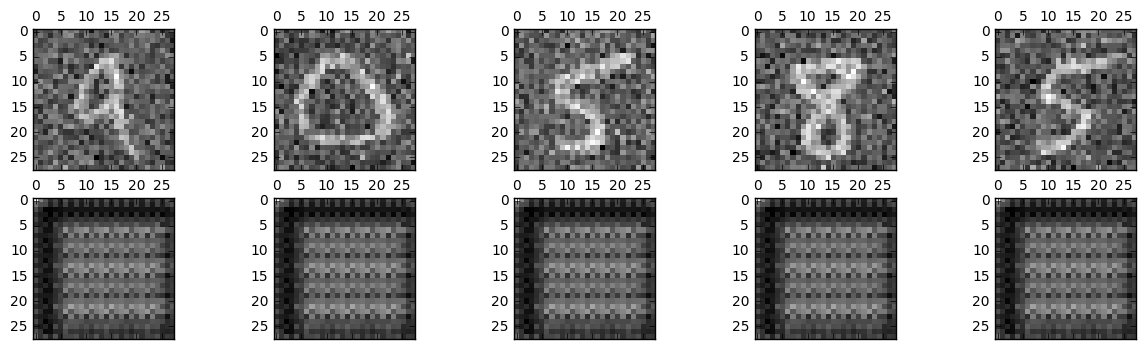

[01/20] cost: 0.0497


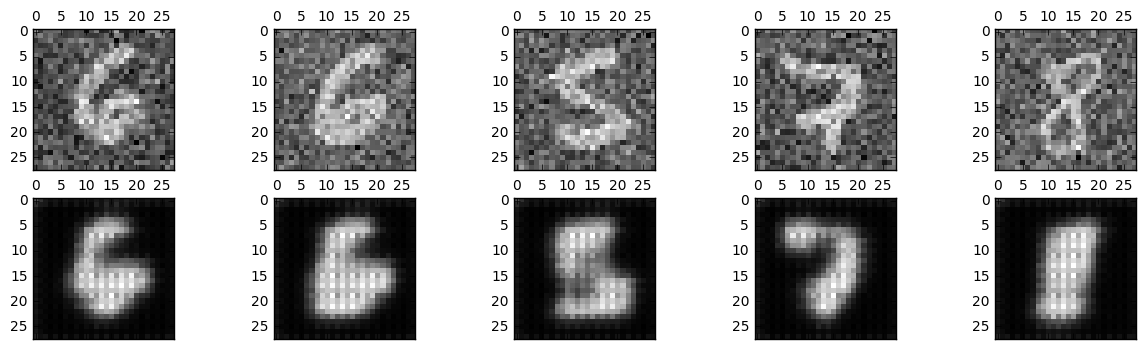

[02/20] cost: 0.0307


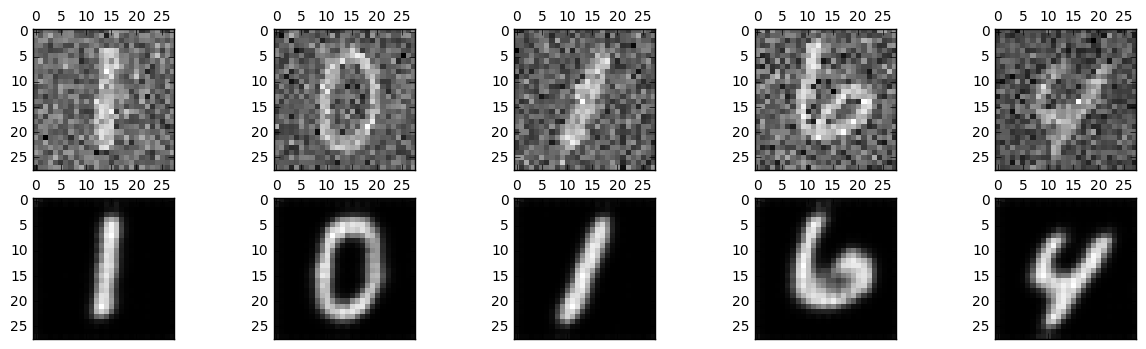

[03/20] cost: 0.0263


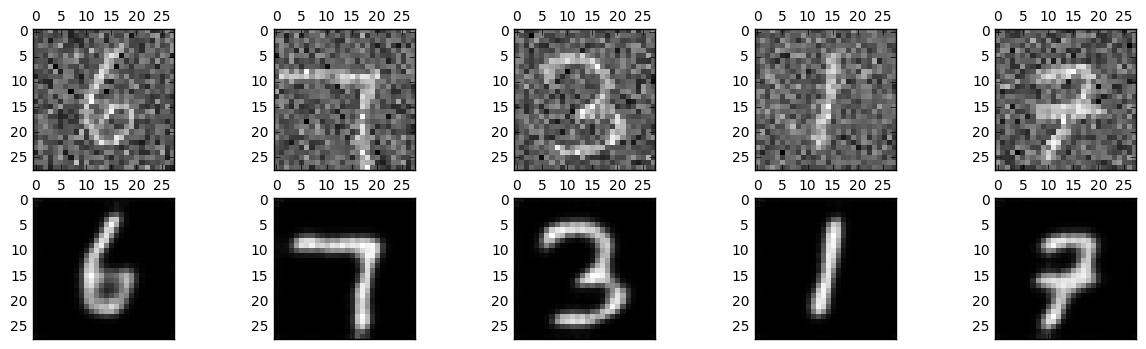

[04/20] cost: 0.0226


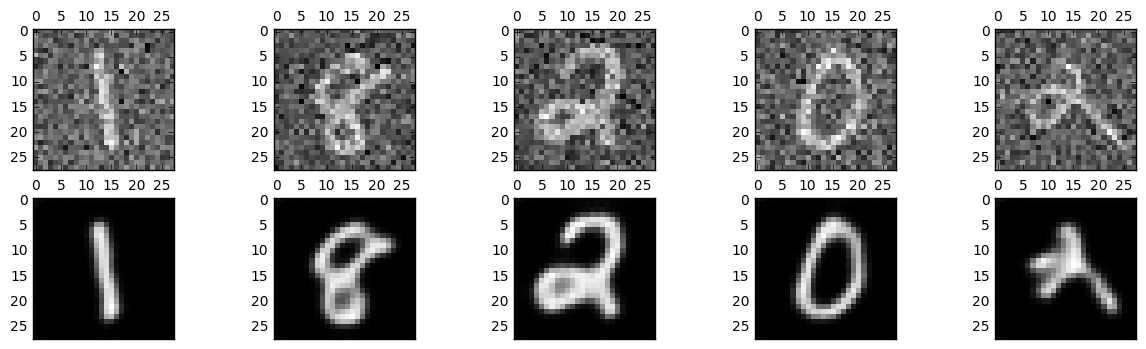

[05/20] cost: 0.0203


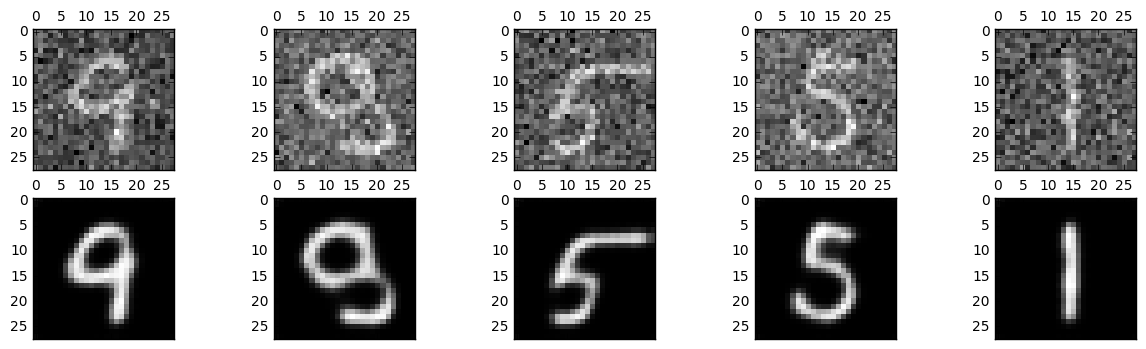

[06/20] cost: 0.0205


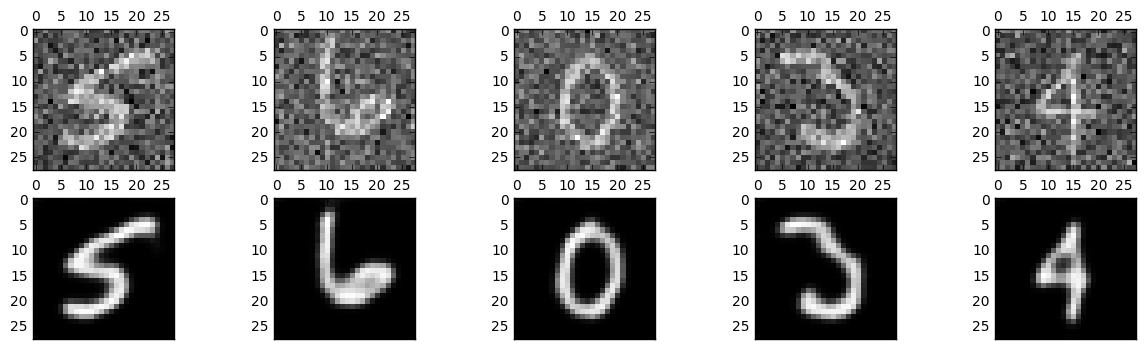

[07/20] cost: 0.0198


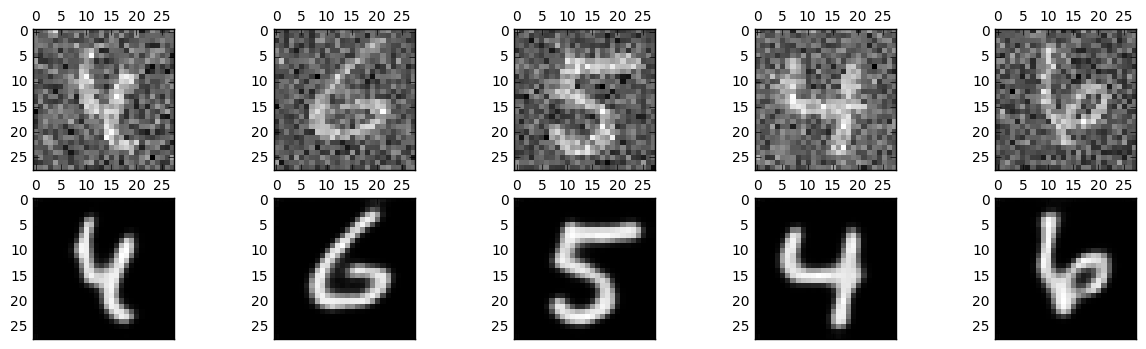

[08/20] cost: 0.0200


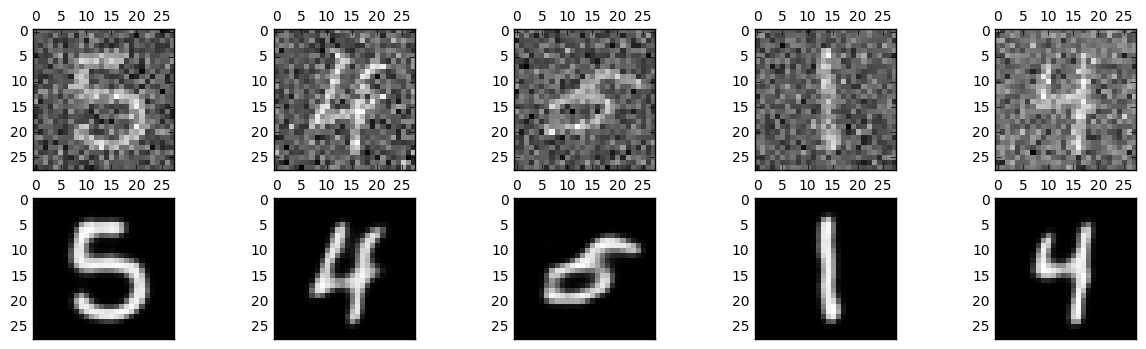

[09/20] cost: 0.0182


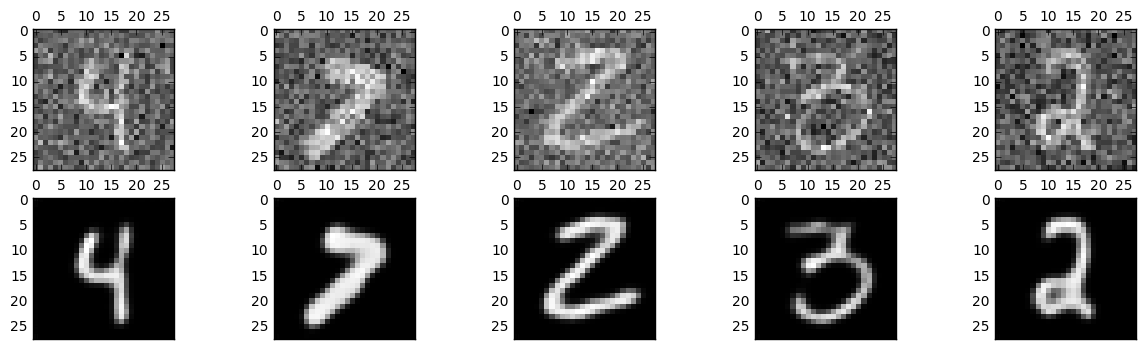

[10/20] cost: 0.0184


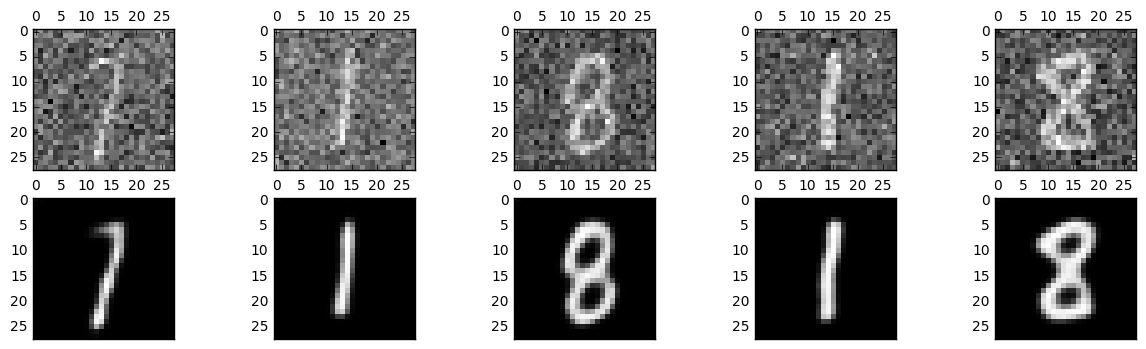

[11/20] cost: 0.0183


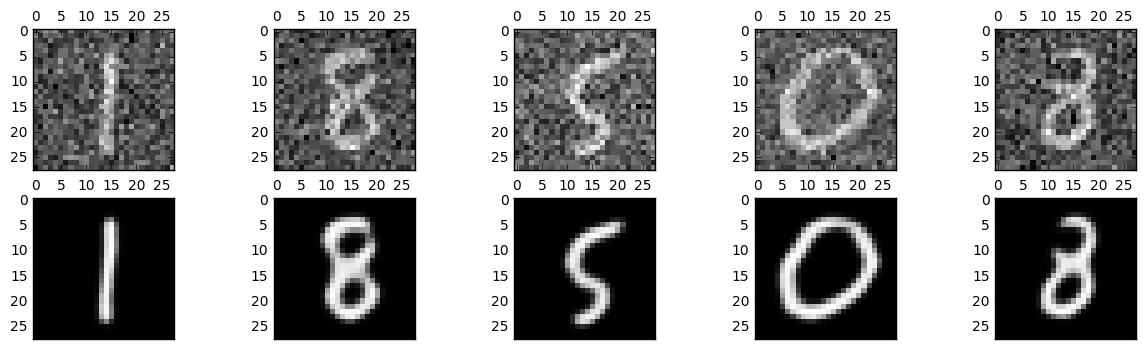

[12/20] cost: 0.0173


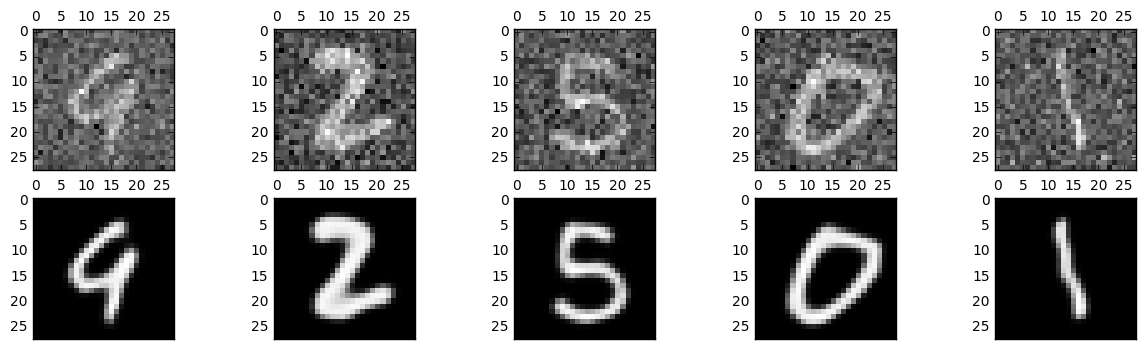

[13/20] cost: 0.0179


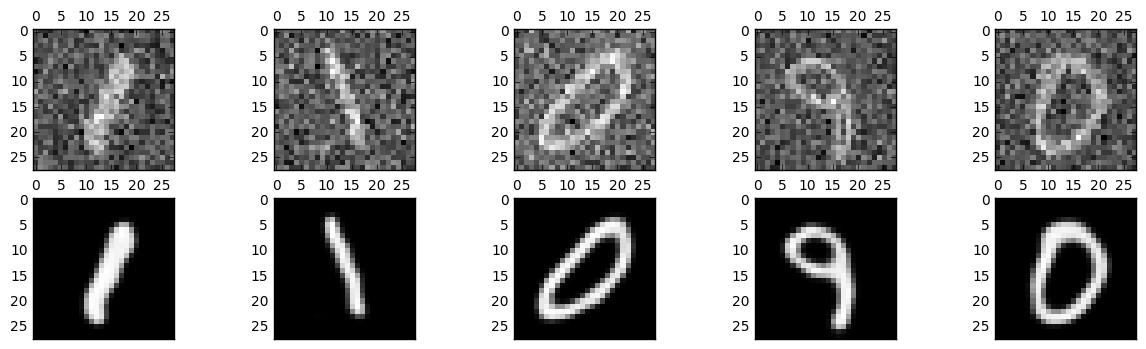

[14/20] cost: 0.0184


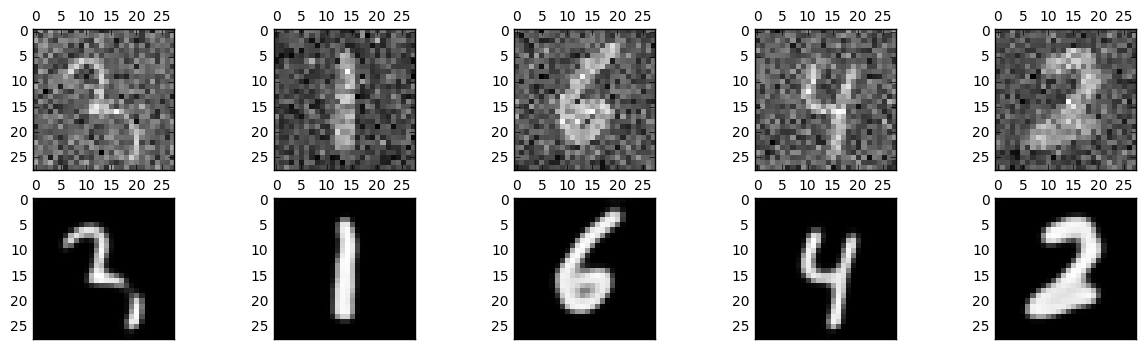

[15/20] cost: 0.0173


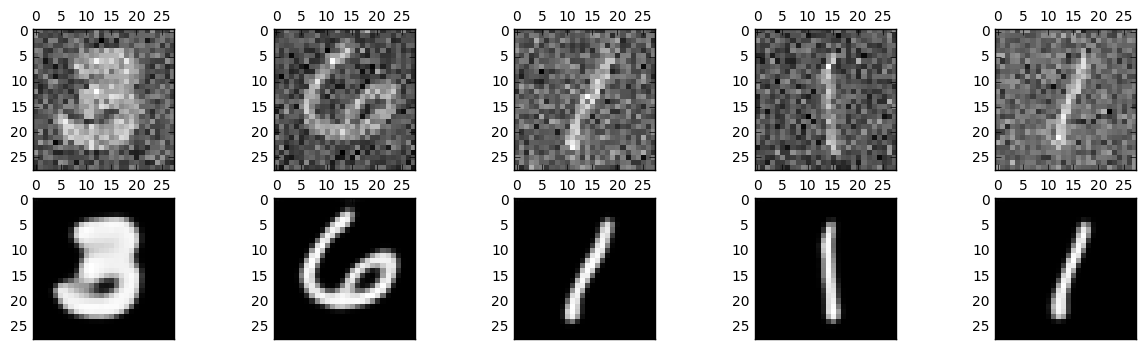

[16/20] cost: 0.0173


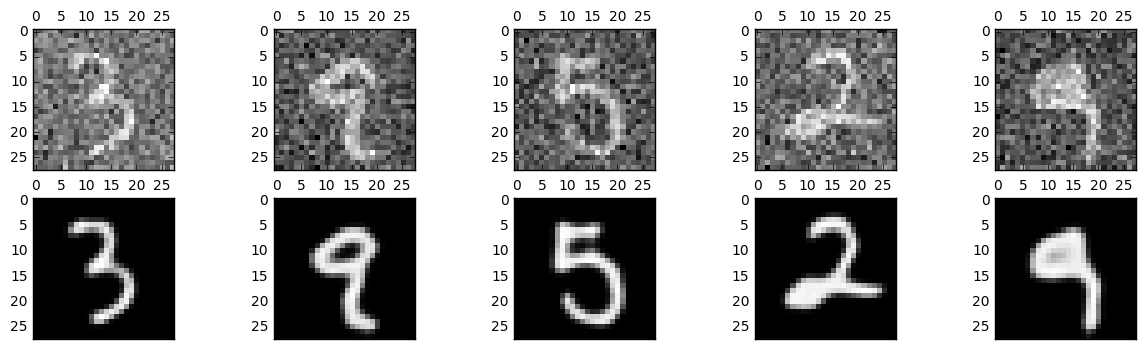

[17/20] cost: 0.0178


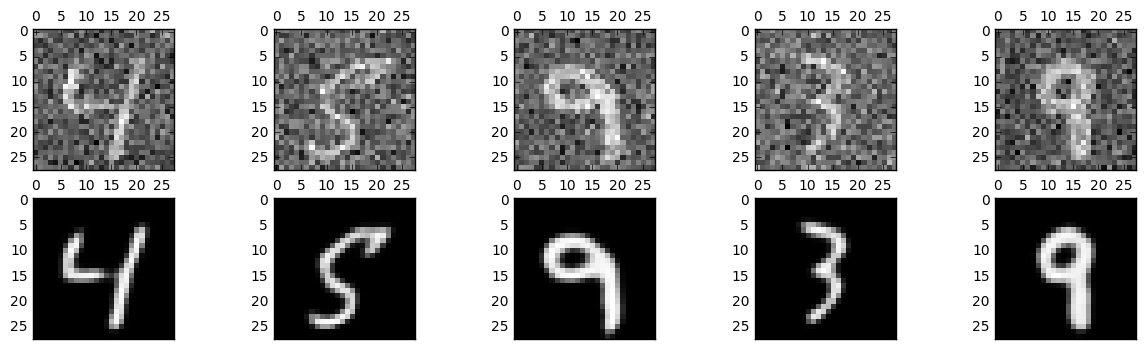

[18/20] cost: 0.0178


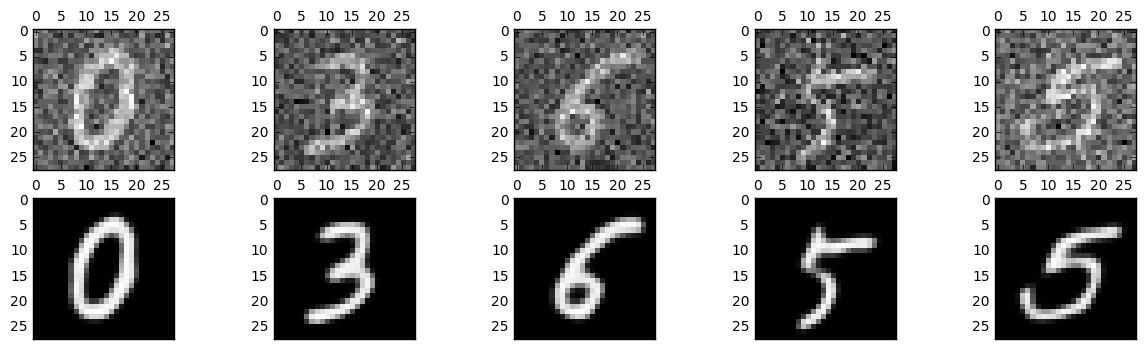

[19/20] cost: 0.0165


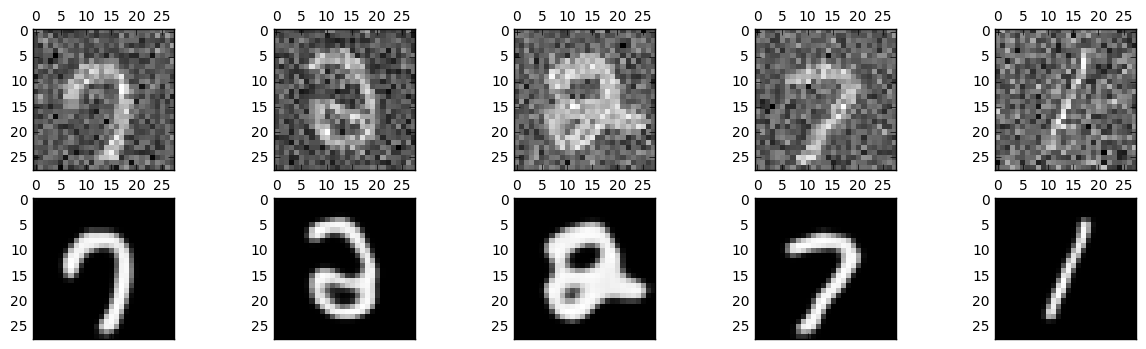

Training done. 


In [20]:
sess = tf.Session()
sess.run(init)
# mean_img = np.mean(mnist.train.images, axis=0)
mean_img = np.zeros((784))
# Fit all training data
batch_size = 128
n_epochs   = 20
print("Strart training..")
for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        trainbatch = np.array([img - mean_img for img in batch_xs])
        trainbatch_noisy = trainbatch + 0.3*np.random.randn(
            trainbatch.shape[0], 784)
        sess.run(optm, feed_dict={x: trainbatch_noisy
                                  , y: trainbatch, keepprob: 0.7})
    print ("[%02d/%02d] cost: %.4f" % (epoch_i, n_epochs
        , sess.run(cost, feed_dict={x: trainbatch_noisy
                                    , y: trainbatch, keepprob: 1.})))
    if (epoch_i % 1) == 0:
        n_examples = 5
        test_xs, _ = mnist.test.next_batch(n_examples)
        test_xs_noisy = test_xs + 0.3*np.random.randn(
            test_xs.shape[0], 784)
        recon = sess.run(pred, feed_dict={x: test_xs_noisy, keepprob: 1.})
        fig, axs = plt.subplots(2, n_examples, figsize=(15, 4))
        for example_i in range(n_examples):
            axs[0][example_i].matshow(np.reshape(
                test_xs_noisy[example_i, :], (28, 28))
                , cmap=plt.get_cmap('gray'))
            axs[1][example_i].matshow(np.reshape(
                np.reshape(recon[example_i, ...], (784,))
                + mean_img, (28, 28)), cmap=plt.get_cmap('gray'))
        plt.show()
print("Training done. ")

## PRINT SHAPE OF THE NETWORK

In [21]:
test_xs, _ = mnist.test.next_batch(1)
test_xs_norm = np.array([img - mean_img for img in test_xs])
recon = sess.run(pred, feed_dict={x: test_xs_norm, keepprob: 1.})
layers = sess.run(cae(x, weights, biases, keepprob)['layers']
                  , feed_dict={x: test_xs_norm, keepprob: 1.})
for i in range(len(layers)):
    currl = layers[i]
    print (("Shape of layer %d is %s") % (i+1, currl.shape,))

Shape of layer 1 is (1, 28, 28, 1)
Shape of layer 2 is (1, 4, 4, 64)
Shape of layer 3 is (1, 7, 7, 32)
Shape of layer 4 is (1, 4, 4, 64)
Shape of layer 5 is (1, 7, 7, 32)
Shape of layer 6 is (1, 14, 14, 16)
Shape of layer 7 is (1, 28, 28, 1)
